In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
from scipy.stats.mstats import winsorize
#from __future__ import division, print_function
from builtins import reversed
from builtins import map, zip
from collections.abc import MutableSequence, Sequence
import copy
from math import ceil
from numbers import Complex, Integral, Real
import sys
import warnings
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import kendalltau
import cvxpy as cp
from scipy.optimize import minimize
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from scipy.stats import rankdata

### **4) Extensions to Hierarchical Risk Parity:** 
##### So far, our primary object for encoding of the dependence information is the correlation matrix. The HRP optimization of Lopez De Prado (2016) offers a framework for generalizing beyond this. When we consider the warning on correlations expressed in Embrechts, McNeil and Straumann (1999), Correlation Pitfalls and Alternatives, it appears both critical and productive to search in the direction of generalizing our measure of dependence.

##### (a) Consider the distance matrix, D, defined in Lopez De Prado (2016, p.5). This measure is still based on the correlation matrix. Now, Embrechts, McNeil, Straumann (1999) in Correlation and dependency in risk management, properties and pitfalls, express alternative distance metrics (page 17, a la, Schweizer and Wolf, 1981), that may be able to capture additional dependence information and be used in the HRP portfolio optimization context. Build an alternative HRP optimization that uses one of these distances for the distance matrix D.

In [47]:
def get_cluster_var(cov_matrix: np.ndarray, cluster: list):
    sub = cov_matrix[np.ix_(cluster, cluster)]
    inv_var = 1.0 / np.diag(sub)
    ivp = inv_var / inv_var.sum()
    return float(ivp.T @ sub @ ivp)

def get_quasi_diag(link: np.ndarray):
    link = link.astype(int)
    num_items = link[-1, 3]
    order = [link[-1, 0], link[-1, 1]]
    while any(item >= num_items for item in order):
        new_order = []
        for item in order:
            if item < num_items:
                new_order.append(item)
            else:
                idx = int(item - num_items)
                new_order.append(link[idx, 0])
                new_order.append(link[idx, 1])
        order = new_order
    return order

def get_rec_bipart(cov_matrix: np.ndarray, order: list):
    n = cov_matrix.shape[0]
    w = np.ones(n)
    clusters = [order]
    while clusters:
        next_clusters = []
        for cluster in clusters:
            if len(cluster) <= 1:
                continue
            k = len(cluster) // 2
            c1 = cluster[:k]
            c2 = cluster[k:]
            var1 = get_cluster_var(cov_matrix, c1)
            var2 = get_cluster_var(cov_matrix, c2)
            alpha = 1 - var1 / (var1 + var2)
            w[c1] *= alpha
            w[c2] *= (1 - alpha)
            next_clusters += [c1, c2]
        clusters = next_clusters
    return w

def compute_kendall_distance_matrix(returns_df: pd.DataFrame):
    n = returns_df.shape[1]
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            tau, _ = kendalltau(returns_df.iloc[:, i], returns_df.iloc[:, j])
            d = np.sqrt(0.5 * (1 - tau))
            dist[i, j] = dist[j, i] = d
    return dist

def hierarchical_risk_parity_kendall(returns_df, cov, method: str = 'single'):
    # 1) Calculer la distance basée sur Kendall's tau
    dist = compute_kendall_distance_matrix(returns_df)
    dist_condensed = squareform(dist, checks=False)

    # 2) Clustering hiérarchique
    link = linkage(dist_condensed, method=method)

    # 3) Ordre quasi-diagonal
    order = get_quasi_diag(link)

    # 4) Calculer la matrice de covariance pour l’allocation
    #cov_matrix = returns_df.cov().values   ?????
    cov_matrix = cov

    # 5) Allocation HRP
    w = get_rec_bipart(cov_matrix, order)
    return w / np.sum(w)

##### (b) Solve your new portfolio for both dates, datePP and dateTr and compare the weights the those in the Question 3a) and discuss any interesting findings.

In [48]:
# Let's compute the weights with our HRP 'revisited'
HRP_kendall_weights_PP = hierarchical_risk_parity_kendall(rets_PP,cov_PP_clean)
HRP_kendall_weights_Tr = hierarchical_risk_parity_kendall(rets_Tr,cov_Tr_clean)
HRP_kendall_weights_PP_sofr = hierarchical_risk_parity_kendall(rets_PP_sofr,cov_PP_clean_sofr)
HRP_kendall_weights_Tr_sofr = hierarchical_risk_parity_kendall(rets_Tr_sofr,cov_Tr_clean_sofr)

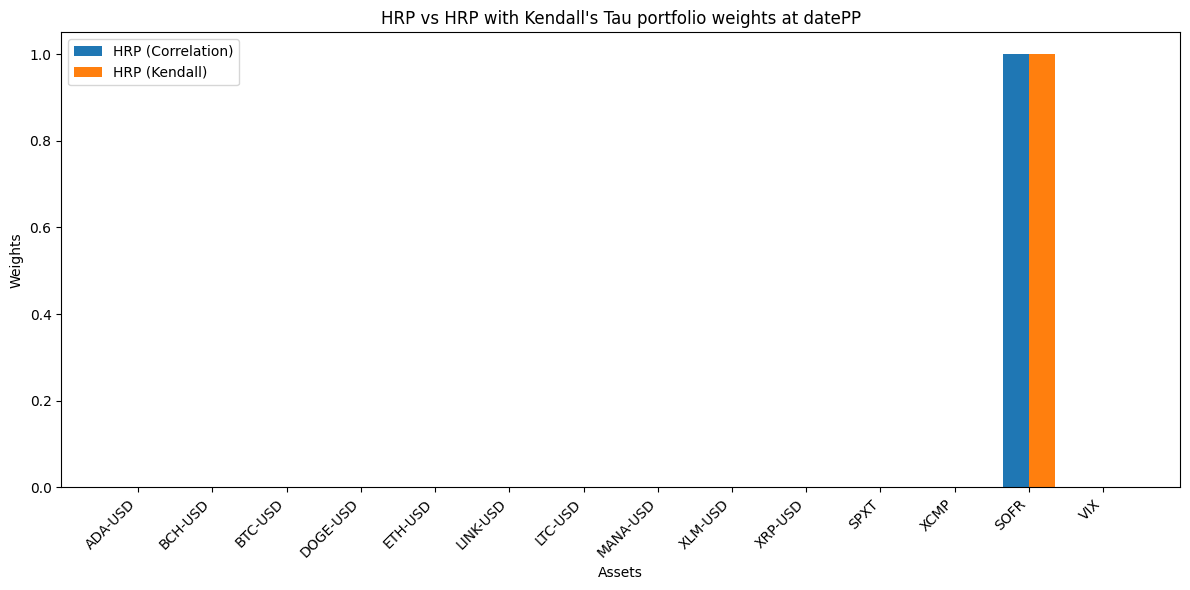

In [49]:
# HRP classique avec SOFR 
weights_corr = pd.Series(HRP_weights_PP, index=cov_PP.columns)

# HRP Kendall avec SOFR 
weights_kendall = pd.Series(HRP_kendall_weights_PP, index=cov_PP.columns)

# Vérifions que les deux index sont identiques (ordre et noms)
assert all(weights_corr.index == weights_kendall.index)

# Construction du DataFrame pour le plot
df_compare = pd.DataFrame({
    'HRP (Corr)': weights_corr,
    'HRP (Kendall)': weights_kendall
})

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(df_compare))

ax.bar(index, df_compare['HRP (Corr)'], bar_width, label='HRP (Correlation)')
ax.bar(index + bar_width, df_compare['HRP (Kendall)'], bar_width, label='HRP (Kendall)')

ax.set_xlabel('Assets')
ax.set_ylabel('Weights')
ax.set_title('HRP vs HRP with Kendall\'s Tau portfolio weights at datePP')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_compare.index, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

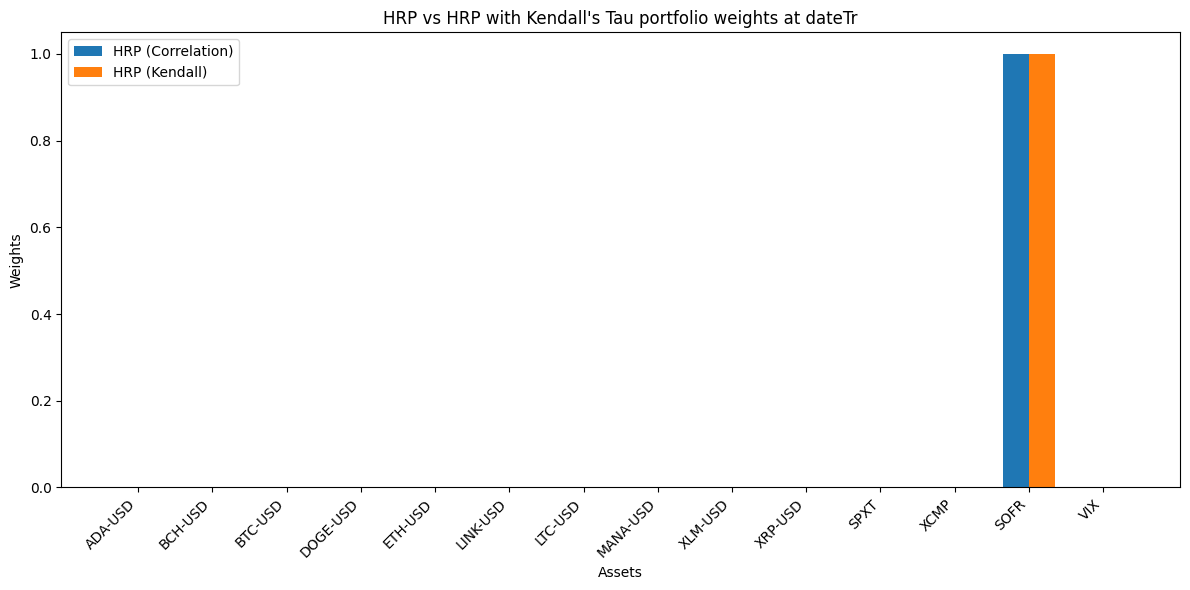

In [50]:
# HRP classique avec SOFR 
weights_corr = pd.Series(HRP_weights_Tr, index=cov_Tr.columns)

# HRP Kendall avec SOFR 
weights_kendall = pd.Series(HRP_kendall_weights_Tr, index=cov_Tr.columns)

# Vérifions que les deux index sont identiques (ordre et noms)
assert all(weights_corr.index == weights_kendall.index)

# Construction du DataFrame pour le plot
df_compare = pd.DataFrame({
    'HRP (Corr)': weights_corr,
    'HRP (Kendall)': weights_kendall
})

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(df_compare))

ax.bar(index, df_compare['HRP (Corr)'], bar_width, label='HRP (Correlation)')
ax.bar(index + bar_width, df_compare['HRP (Kendall)'], bar_width, label='HRP (Kendall)')

ax.set_xlabel('Assets')
ax.set_ylabel('Weights')
ax.set_title('HRP vs HRP with Kendall\'s Tau portfolio weights at dateTr')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_compare.index, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

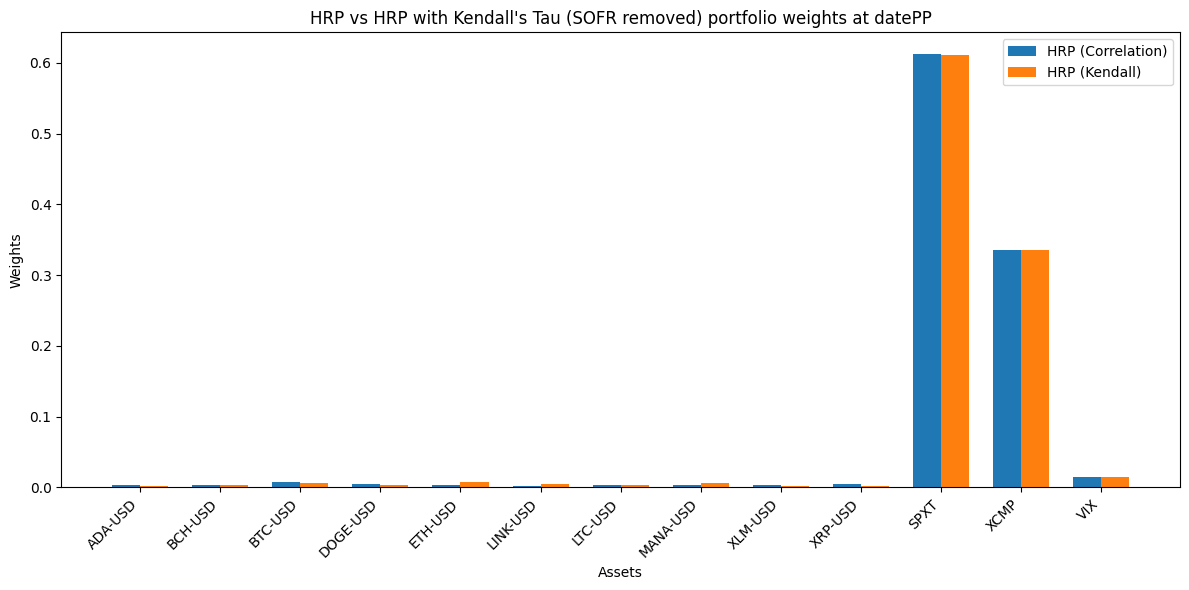

In [51]:
# HRP classique sans SOFR 
weights_corr = pd.Series(HRP_weights_PP_sofr, index=cov_PP_sofr.columns)

# HRP Kendall sans SOFR 
weights_kendall = pd.Series(HRP_kendall_weights_PP_sofr, index=rets_PP_sofr.columns)

# Vérifions que les deux index sont identiques (ordre et noms)
assert all(weights_corr.index == weights_kendall.index)

# Construction du DataFrame pour le plot
df_compare = pd.DataFrame({
    'HRP (Corr)': weights_corr,
    'HRP (Kendall)': weights_kendall
})

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(df_compare))

ax.bar(index, df_compare['HRP (Corr)'], bar_width, label='HRP (Correlation)')
ax.bar(index + bar_width, df_compare['HRP (Kendall)'], bar_width, label='HRP (Kendall)')

ax.set_xlabel('Assets')
ax.set_ylabel('Weights')
ax.set_title('HRP vs HRP with Kendall\'s Tau (SOFR removed) portfolio weights at datePP')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_compare.index, rotation=45, ha='right')
ax.legend()


plt.tight_layout()
plt.show()

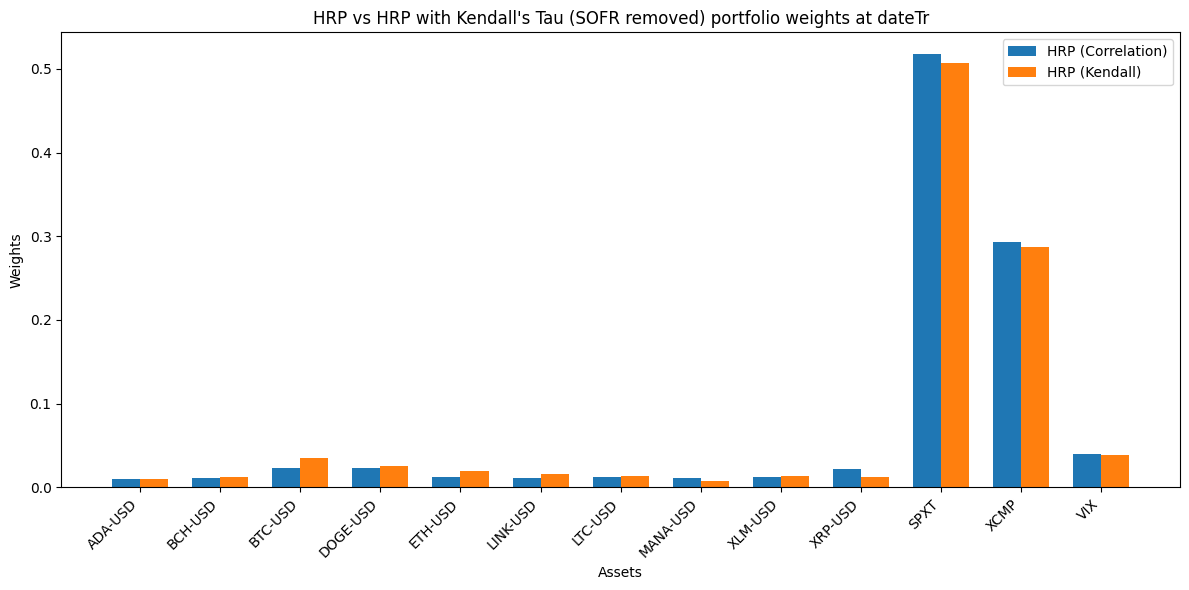

In [52]:
# HRP classique sans SOFR 
weights_corr = pd.Series(HRP_weights_Tr_sofr, index=cov_Tr_sofr.columns)

# HRP Kendall sans SOFR 
weights_kendall = pd.Series(HRP_kendall_weights_Tr_sofr, index=rets_Tr_sofr.columns)

# Vérifions que les deux index sont identiques (ordre et noms)
assert all(weights_corr.index == weights_kendall.index)

# Construction du DataFrame pour le plot
df_compare = pd.DataFrame({
    'HRP (Corr)': weights_corr,
    'HRP (Kendall)': weights_kendall
})

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(df_compare))

ax.bar(index, df_compare['HRP (Corr)'], bar_width, label='HRP (Correlation)')
ax.bar(index + bar_width, df_compare['HRP (Kendall)'], bar_width, label='HRP (Kendall)')

ax.set_xlabel('Assets')
ax.set_ylabel('Weights')
ax.set_title('HRP vs HRP with Kendall\'s Tau (SOFR removed) portfolio weights at dateTr')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_compare.index, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

Lets redo question a, using the first distance metric defined on page 17 as 
$$\delta(X,Y) = 12 \int_0^1\int_0^1 \vert C(u,v) - uv)\vert dudv$$
C is actually simply the joint density function of X and Y, which we can estimate with our data! So let's get to it

In [ ]:
def empirical_copula_distance(x, y, grid_size=30): # We use grid_size 30, so that computation is fast. We tested against 100 and it is not significantly different.
    """
    Compute the copula-based distance:
    d = 12 * ∫∫ |C(u,v) - uv| du dv
    using empirical ranks and a uniform grid.

    Parameters:
        x, y: 1D arrays or Series of returns
        grid_size: Number of grid points in [0, 1]²

    Returns:
        float: distance value
    """
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)

    # Rank-transform to [0,1]
    u = rankdata(x) / (n + 1)
    v = rankdata(y) / (n + 1)

    # Create grid
    grid = np.linspace(0, 1, grid_size)
    du = dv = 1 / grid_size
    dist_sum = 0.0

    for ui in grid:
        for vi in grid:
            emp_copula = np.mean((u <= ui) & (v <= vi))
            indep_copula = ui * vi
            dist_sum += np.abs(emp_copula - indep_copula)

    return 12 * dist_sum * du * dv

def compute_copula_distance_matrix(returns_df, grid_size=30): # We use grid_size 30, so that computation is fast. We tested against 100 and it is not significantly different.
    """
    Compute the NxN pairwise copula distance matrix for a return DataFrame.

    Parameters:
        returns_df: pd.DataFrame of log returns (T x N)
        grid_size: resolution of [0,1] grid (default = 100)

    Returns:
        np.ndarray: NxN symmetric distance matrix
    """
    cols = returns_df.columns
    n = len(cols)
    dist = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):
            d = empirical_copula_distance(returns_df.iloc[:, i], returns_df.iloc[:, j], grid_size=grid_size)
            dist[i, j] = dist[j, i] = d

    return pd.DataFrame(dist, index=cols, columns=cols)


In [54]:
def get_cluster_var(cov_matrix: np.ndarray, cluster: list):
    sub = cov_matrix[np.ix_(cluster, cluster)]
    inv_var = 1.0 / np.diag(sub)
    ivp = inv_var / inv_var.sum()
    return float(ivp.T @ sub @ ivp)

def get_quasi_diag(link: np.ndarray):
    link = link.astype(int)
    num_items = link[-1, 3]
    order = [link[-1, 0], link[-1, 1]]
    while any(item >= num_items for item in order):
        new_order = []
        for item in order:
            if item < num_items:
                new_order.append(item)
            else:
                idx = int(item - num_items)
                new_order.append(link[idx, 0])
                new_order.append(link[idx, 1])
        order = new_order
    return order

def get_rec_bipart(cov_matrix: np.ndarray, order: list):
    n = cov_matrix.shape[0]
    w = np.ones(n)
    clusters = [order]
    while clusters:
        next_clusters = []
        for cluster in clusters:
            if len(cluster) <= 1:
                continue
            k = len(cluster) // 2
            c1 = cluster[:k]
            c2 = cluster[k:]
            var1 = get_cluster_var(cov_matrix, c1)
            var2 = get_cluster_var(cov_matrix, c2)
            alpha = 1 - var1 / (var1 + var2)
            w[c1] *= alpha
            w[c2] *= (1 - alpha)
            next_clusters += [c1, c2]
        clusters = next_clusters
    return w


def hierarchical_risk_parity_copula(returns_df, cov, method: str = 'single', grid_size=30):
    # 1) Calculer la distance basée sur Kendall's tau
    dist = compute_copula_distance_matrix(returns_df, grid_size=grid_size)
    dist_condensed = squareform(dist, checks=False)

    # 2) Clustering hiérarchique
    link = linkage(dist_condensed, method=method)

    # 3) Ordre quasi-diagonal
    order = get_quasi_diag(link)

    # 4) Calculer la matrice de covariance pour l’allocation
    #cov_matrix = returns_df.cov().values   ?????
    cov_matrix = cov

    # 5) Allocation HRP
    w = get_rec_bipart(cov_matrix, order)
    return w / np.sum(w)

In [55]:
HRP_copula_weights_PP = hierarchical_risk_parity_copula(rets_PP,cov_PP_clean)
HRP_copula_weights_Tr = hierarchical_risk_parity_copula(rets_Tr,cov_Tr_clean)
HRP_copula_weights_PP_sofr = hierarchical_risk_parity_copula(rets_PP_sofr,cov_PP_clean_sofr)
HRP_copula_weights_Tr_sofr = hierarchical_risk_parity_copula(rets_Tr_sofr,cov_Tr_clean_sofr)

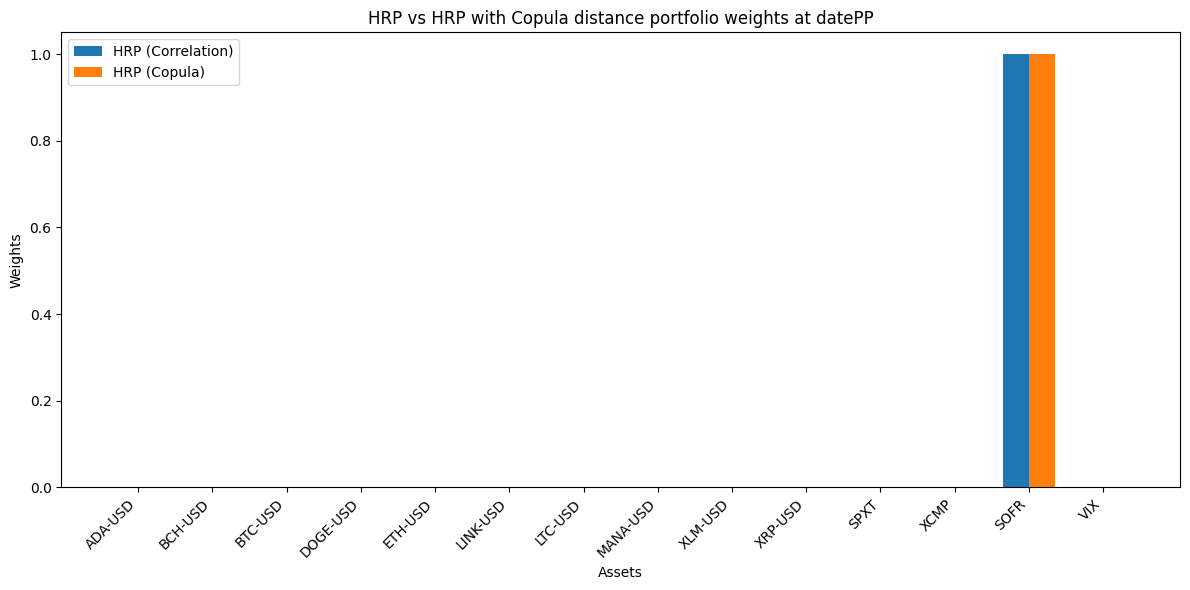

In [56]:
# HRP classique avec SOFR 
weights_corr = pd.Series(HRP_weights_PP, index=cov_PP.columns)

# HRP Kendall avec SOFR 
weights_copula = pd.Series(HRP_copula_weights_PP, index=cov_PP.columns)

# Vérifions que les deux index sont identiques (ordre et noms)
assert all(weights_corr.index == weights_copula.index)

# Construction du DataFrame pour le plot
df_compare = pd.DataFrame({
    'HRP (Corr)': weights_corr,
    'HRP (Copula)': weights_copula
})

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(df_compare))

ax.bar(index, df_compare['HRP (Corr)'], bar_width, label='HRP (Correlation)')
ax.bar(index + bar_width, df_compare['HRP (Copula)'], bar_width, label='HRP (Copula)')

ax.set_xlabel('Assets')
ax.set_ylabel('Weights')
ax.set_title('HRP vs HRP with Copula distance portfolio weights at datePP')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_compare.index, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

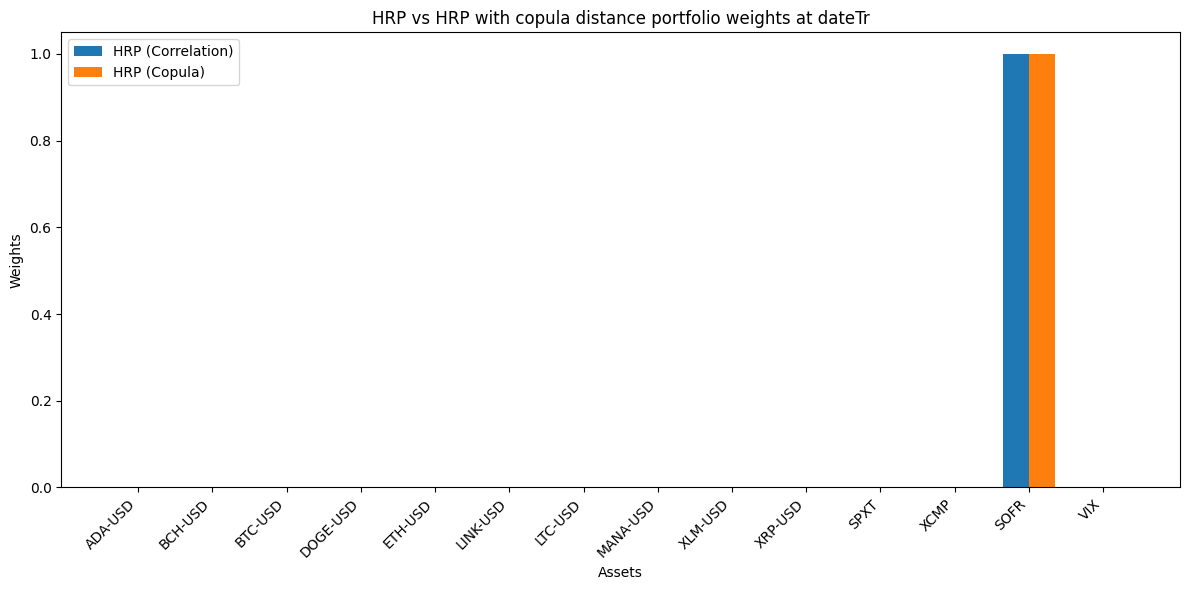

In [57]:
# HRP classique avec SOFR 
weights_corr = pd.Series(HRP_weights_Tr, index=cov_Tr.columns)

# HRP Kendall avec SOFR 
weights_copula = pd.Series(HRP_copula_weights_Tr, index=cov_Tr.columns)

# Vérifions que les deux index sont identiques (ordre et noms)
assert all(weights_corr.index == weights_copula.index)

# Construction du DataFrame pour le plot
df_compare = pd.DataFrame({
    'HRP (Corr)': weights_corr,
    'HRP (Copula)': weights_copula
})

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(df_compare))

ax.bar(index, df_compare['HRP (Corr)'], bar_width, label='HRP (Correlation)')
ax.bar(index + bar_width, df_compare['HRP (Copula)'], bar_width, label='HRP (Copula)')

ax.set_xlabel('Assets')
ax.set_ylabel('Weights')
ax.set_title('HRP vs HRP with copula distance portfolio weights at dateTr')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_compare.index, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

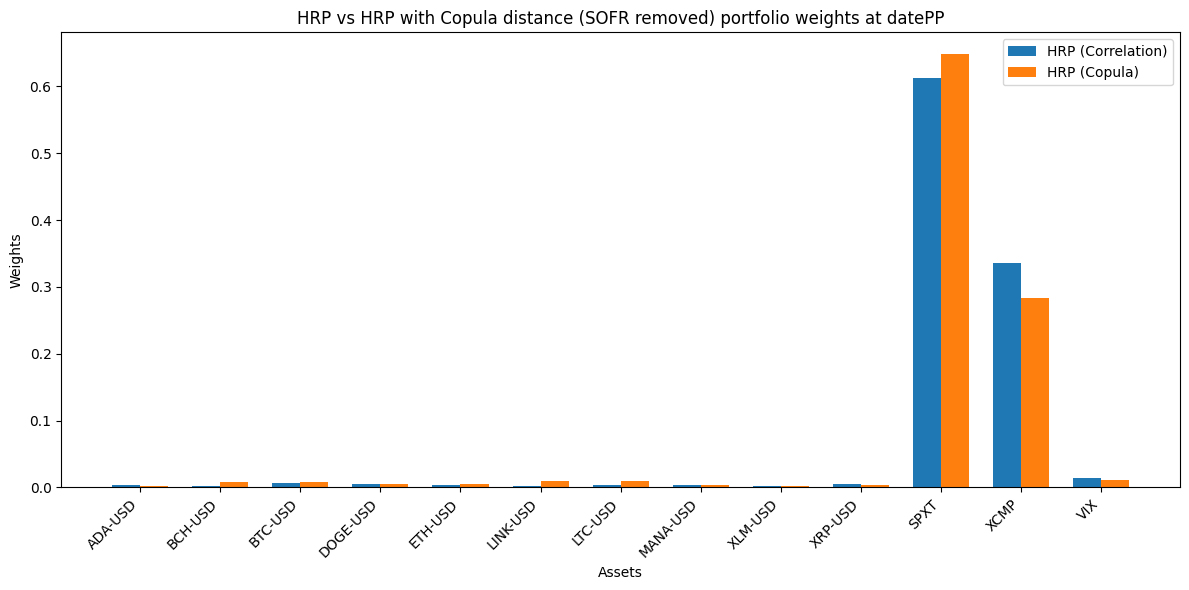

In [58]:
# HRP classique sans SOFR 
weights_corr = pd.Series(HRP_weights_PP_sofr, index=cov_PP_sofr.columns)

# HRP Kendall sans SOFR 
weights_copula = pd.Series(HRP_copula_weights_PP_sofr, index=rets_PP_sofr.columns)

# Vérifions que les deux index sont identiques (ordre et noms)
assert all(weights_corr.index == weights_copula.index)


# Construction du DataFrame pour le plot
df_compare = pd.DataFrame({
    'HRP (Corr)': weights_corr,
    'HRP (Copula)': weights_copula,
})

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(df_compare))

ax.bar(index, df_compare['HRP (Corr)'], bar_width, label='HRP (Correlation)')
ax.bar(index + bar_width, df_compare['HRP (Copula)'], bar_width, label='HRP (Copula)')

ax.set_xlabel('Assets')
ax.set_ylabel('Weights')
ax.set_title('HRP vs HRP with Copula distance (SOFR removed) portfolio weights at datePP')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_compare.index, rotation=45, ha='right')
ax.legend()


plt.tight_layout()
plt.show()

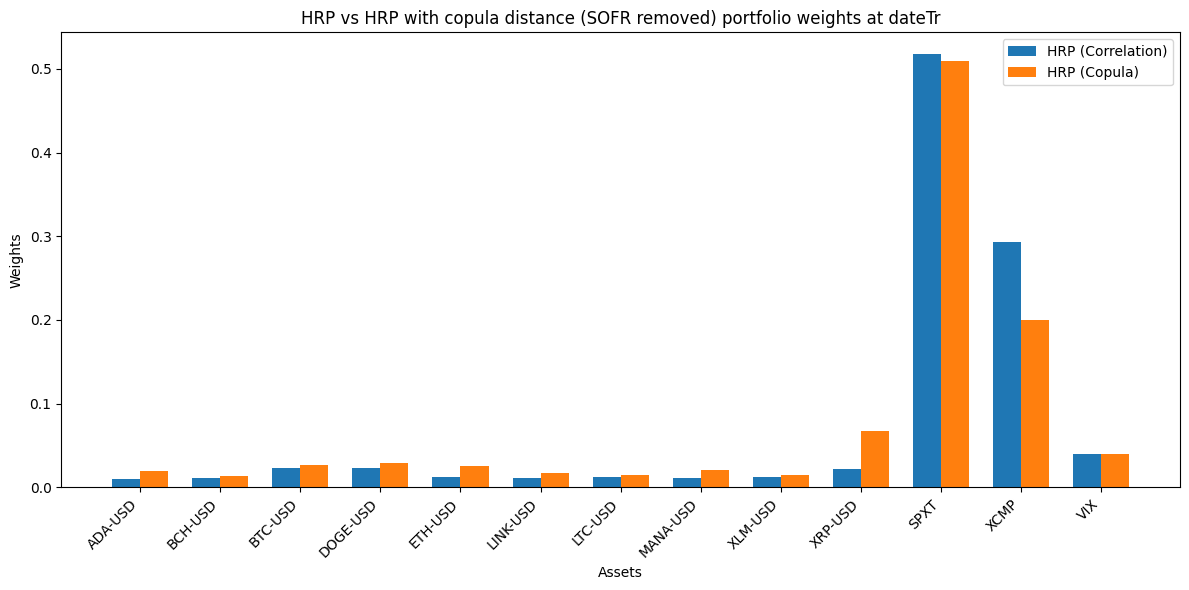

In [59]:
# HRP classique sans SOFR 
weights_corr = pd.Series(HRP_weights_Tr_sofr, index=cov_Tr_sofr.columns)

# HRP Kendall sans SOFR 
weights_copula = pd.Series(HRP_copula_weights_Tr_sofr, index=rets_Tr_sofr.columns)

# Vérifions que les deux index sont identiques (ordre et noms)
assert all(weights_corr.index == weights_copula.index)

# Construction du DataFrame pour le plot
df_compare = pd.DataFrame({
    'HRP (Corr)': weights_corr,
    'HRP (Copula)': weights_copula
})

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(df_compare))

ax.bar(index, df_compare['HRP (Corr)'], bar_width, label='HRP (Correlation)')
ax.bar(index + bar_width, df_compare['HRP (Copula)'], bar_width, label='HRP (Copula)')

ax.set_xlabel('Assets')
ax.set_ylabel('Weights')
ax.set_title('HRP vs HRP with copula distance (SOFR removed) portfolio weights at dateTr')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_compare.index, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

### 4.c)

Now lets implement a strategy! Lets define the signals at each time

In [60]:
def asset_signals(returns, lookback : int = 252):

    # Take the returns on the last year. This works since we have log returns, so cum_returns is the return at the 
    period_returns = returns.rolling(window=lookback).sum()
    

    # Take the sign to generate binary signals
    signals = np.sign(period_returns)


    signals = signals.dropna()

    period_returns = period_returns.dropna()
    
    return signals, period_returns

In [61]:
def implement_hrp_tsm_strategy_copula(rets, lookback: int = 252, rebalance_freq: int = 21):
    """
    TSM-HRP Strategy using user-defined signal, HRP, and clipped covariance functions.

    Parameters:
        rets (pd.DataFrame): Daily log returns (T x N)
        lookback (int): Lookback window for TSM (default: 252 trading days)
        rebalance_freq (int): Rebalance every N trading days (default: 21 = monthly)

    Returns:
        pd.Series: Cumulative strategy return
    """
    # Use your defined signal function
    signals, _ = asset_signals(rets, lookback=lookback)

    strat_returns = []

    for t in range(lookback + rebalance_freq, len(rets), rebalance_freq):
        # Get rolling window and latest signal
        hist_window = rets.iloc[t - lookback:t]
        signal_today = signals.loc[rets.index[t - 1]]
        selected_assets = signal_today[signal_today != 0].index.tolist()

        if len(selected_assets) < 2:
            strat_returns.extend([0] * rebalance_freq)
            continue

        # Filter window and signal for selected assets
        X = hist_window[selected_assets]
        sig = signal_today[selected_assets]

        # Use your clipped covariance function
        cov_clipped = clipped(X.values)

        # Use your Kendall-based HRP allocation
        weights = hierarchical_risk_parity_copula(X, cov_clipped)

        # Apply long/short signals
        weights = weights * sig.values
        weights /= np.sum(np.abs(weights))  # normalize absolute exposure

        # Compute forward return
        fwd = rets[selected_assets].iloc[t:t + rebalance_freq]
        daily_ret = fwd @ weights
        strat_returns.extend(daily_ret)

    # Output cumulative return
    strat_returns = pd.Series(
        strat_returns,
        index=rets.index[lookback + rebalance_freq : lookback + rebalance_freq + len(strat_returns)],
        name="TSM + HRP Strategy"
    )

    cum_return = np.exp(strat_returns.cumsum())

    return cum_return

In [62]:
# Define equally weighted portfolio function
def equal_weighted_portfolio(returns_df):
    """
    Compute the returns of an equally weighted portfolio.

    Parameters:
        returns_df (pd.DataFrame): Daily log returns (T x N)

    Returns:
        pd.Series: Cumulative return of the equally weighted portfolio
    """
    weights = np.ones(returns_df.shape[1]) / returns_df.shape[1]
    portfolio_returns = returns_df @ weights
    return np.exp(portfolio_returns.cumsum())

Let's quickly test one simple strategy, looking back a full year (252 days), and rebalancing every three months (63 days)

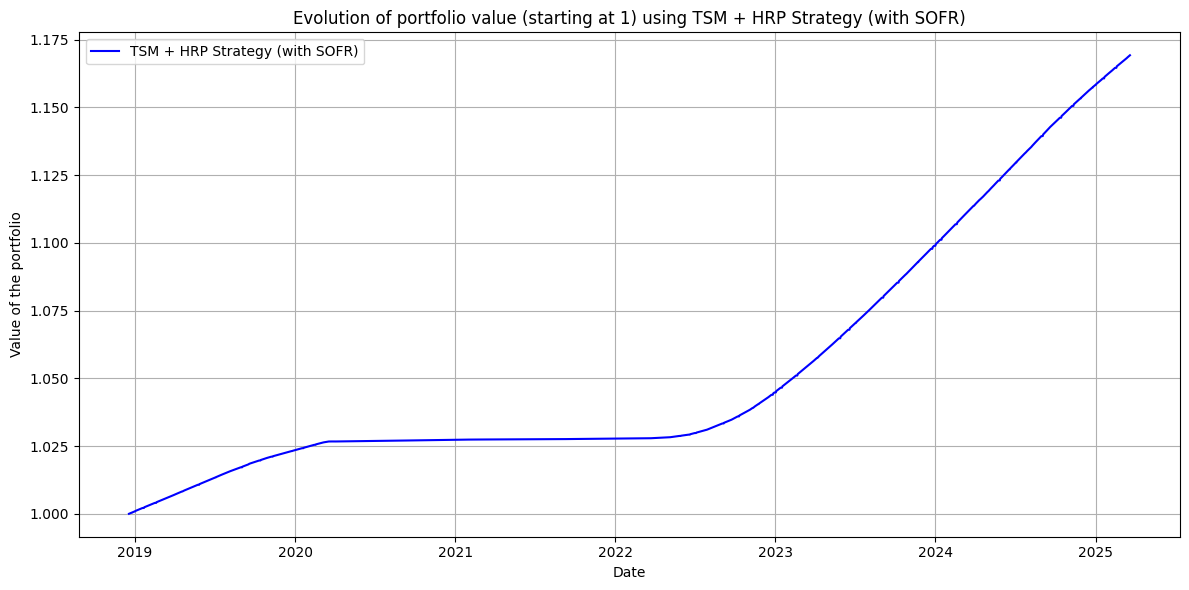

In [66]:
# Run the strategy
strat_copula_with_sofr = implement_hrp_tsm_strategy_copula(rets, lookback=252, rebalance_freq=63)
# Plot it
plt.figure(figsize=(12, 6))
plt.plot(strat_copula_with_sofr, label='TSM + HRP Strategy (with SOFR)', color='blue')
plt.title('Evolution of portfolio value (starting at 1) using TSM + HRP Strategy (with SOFR)')
plt.xlabel('Date')
plt.ylabel('Value of the portfolio')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

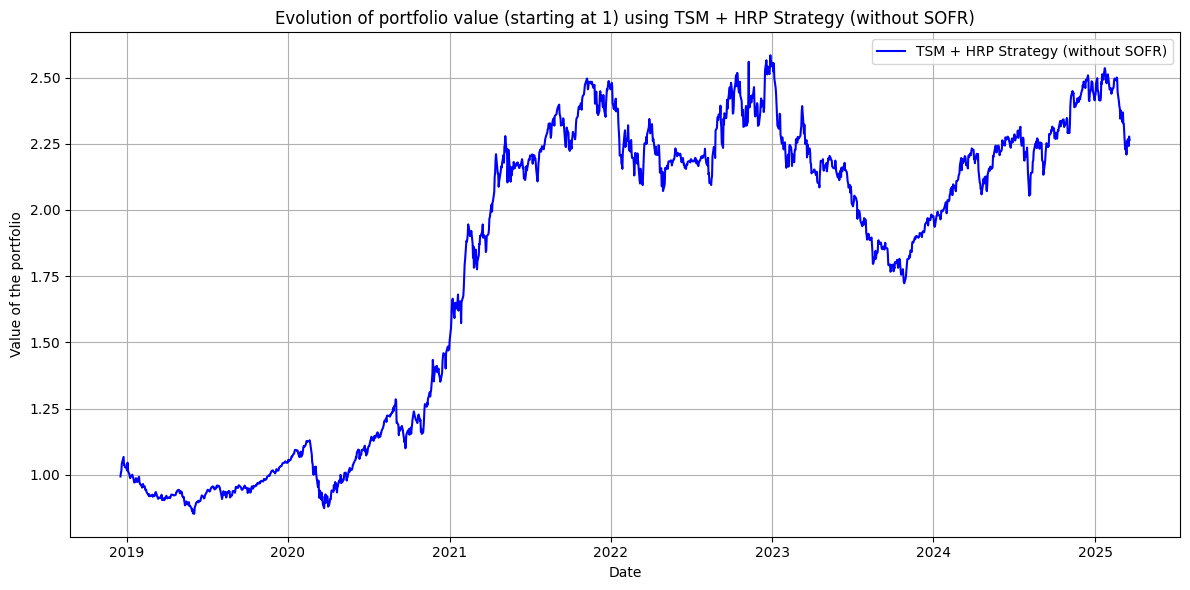

In [67]:
strat_copula_without_sofr = implement_hrp_tsm_strategy_copula(rets_sans_sofr, lookback=252, rebalance_freq=63)
# Plot it
plt.figure(figsize=(12, 6))
plt.plot(strat_copula_without_sofr, label='TSM + HRP Strategy (without SOFR)', color='blue')
plt.title('Evolution of portfolio value (starting at 1) using TSM + HRP Strategy (without SOFR)')
plt.xlabel('Date')
plt.ylabel('Value of the portfolio')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Now, let's do some cross validation to see how different parameters behave, and how it all compares to the equally weighted portfolio

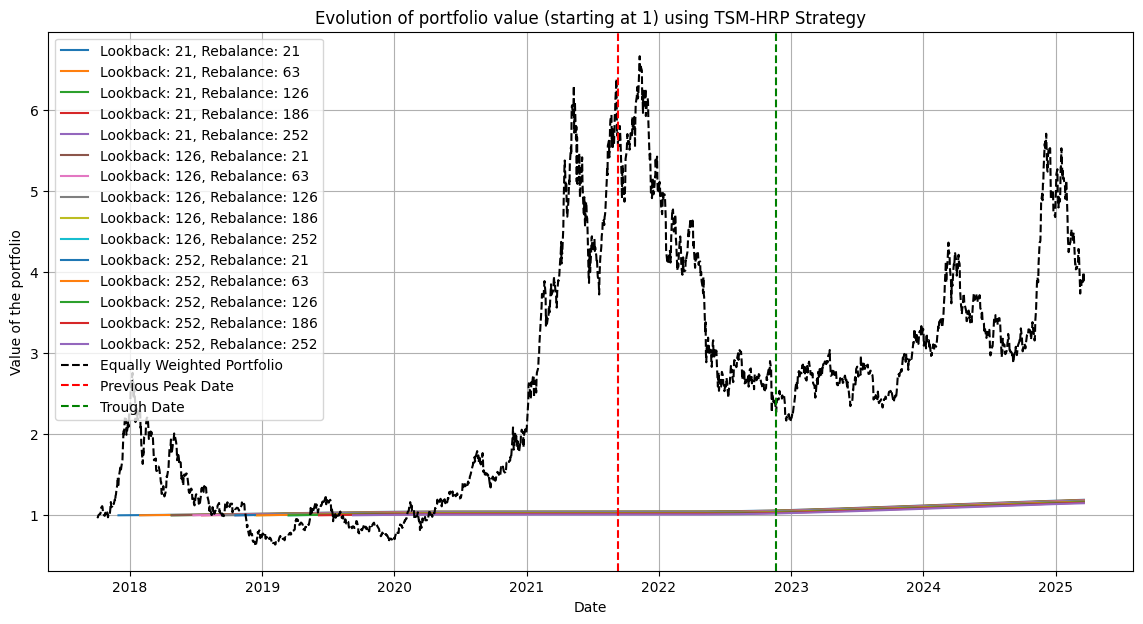

In [63]:
# DO some cross validation
lookback_periods = [21, 126, 252]
rebalance_freqs = [21, 63, 126, 186, 252]
results = []
for lookback in lookback_periods:
    for rebalance_freq in rebalance_freqs:
        # Implement the strategy
        strat_returns = implement_hrp_tsm_strategy_copula(rets, lookback=lookback, rebalance_freq=rebalance_freq)
        results.append((lookback, rebalance_freq, strat_returns))

ewp_returns = equal_weighted_portfolio(rets)
# Plot the results
plt.figure(figsize=(14, 7))
for lookback, rebalance_freq, cum_return in results:
    plt.plot(cum_return, label=f'Lookback: {lookback}, Rebalance: {rebalance_freq}')
# Add equally weighted portfolio for comparison to the last plot
plt.plot(ewp_returns, label='Equally Weighted Portfolio', linestyle='--', color='black')
# Add PP and Tr dates
plt.axvline(x=datePP, color='red', linestyle='--', label='Previous Peak Date')
plt.axvline(x=dateTr, color='green', linestyle='--', label='Trough Date')
plt.title('Evolution of portfolio value (starting at 1) using TSM-HRP Strategy')
plt.xlabel('Date')
plt.ylabel('Value of the portfolio')
plt.legend()
plt.grid()
plt.show()


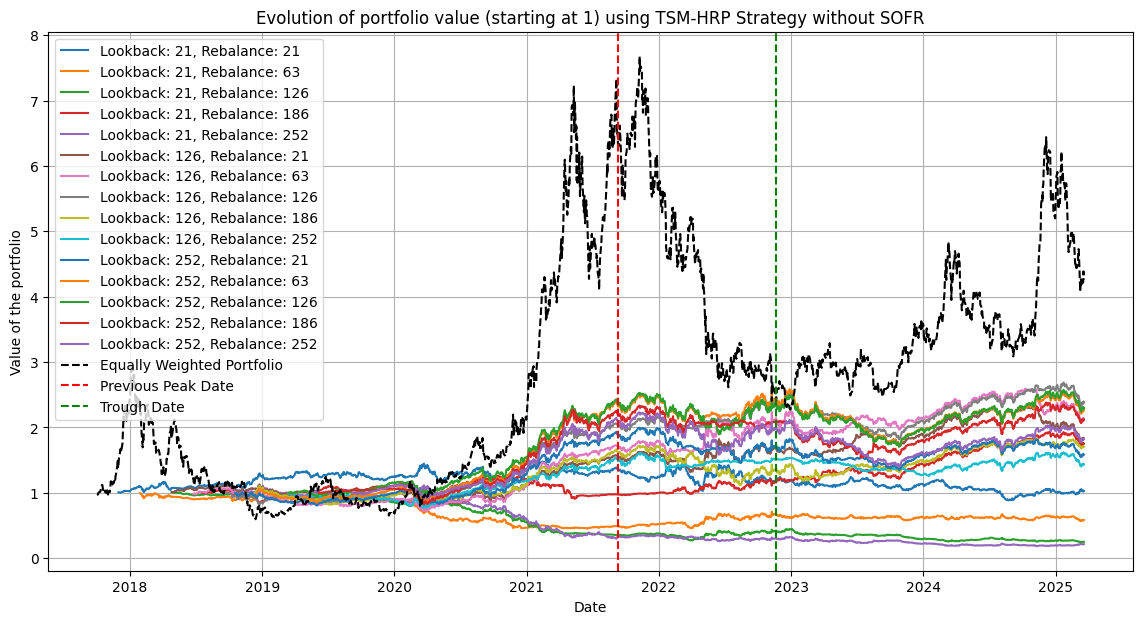

In [64]:
# DO some cross validation
lookback_periods = [21, 126, 252]
rebalance_freqs = [21, 63, 126, 186, 252]
results = []
for lookback in lookback_periods:
    for rebalance_freq in rebalance_freqs:
        # Implement the strategy
        strat_returns = implement_hrp_tsm_strategy_copula(rets_sans_sofr, lookback=lookback, rebalance_freq=rebalance_freq)
        results.append((lookback, rebalance_freq, strat_returns))

ewp_returns = equal_weighted_portfolio(rets_sans_sofr)
# Plot the results
plt.figure(figsize=(14, 7))
for lookback, rebalance_freq, cum_return in results:
    plt.plot(cum_return, label=f'Lookback: {lookback}, Rebalance: {rebalance_freq}')
# Add equally weighted portfolio for comparison to the last plot
plt.plot(ewp_returns, label='Equally Weighted Portfolio', linestyle='--', color='black')
plt.axvline(x=datePP, color='red', linestyle='--', label='Previous Peak Date')
plt.axvline(x=dateTr, color='green', linestyle='--', label='Trough Date')
plt.title('Evolution of portfolio value (starting at 1) using TSM-HRP Strategy without SOFR')
plt.xlabel('Date')
plt.ylabel('Value of the portfolio')
plt.legend()
plt.grid()
plt.show()


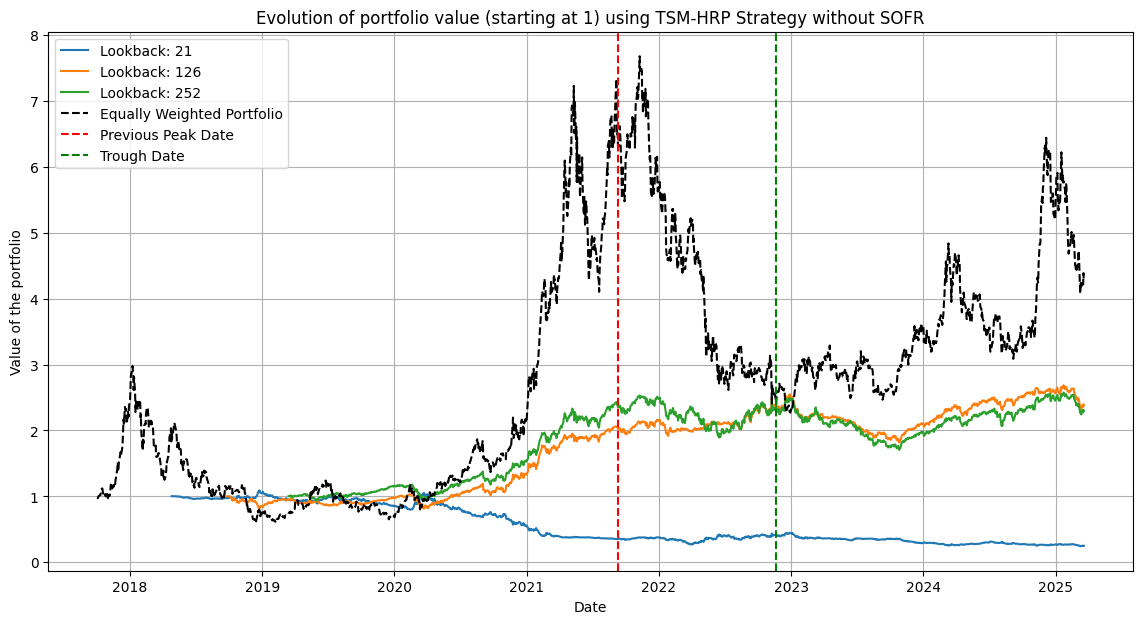

In [68]:
lookback_periods = [21, 126, 252]
# Run 3 strategies, all with rebalancing every 126 days
rebalance_freq = 126
results = []
for lookback in lookback_periods:
    # Implement the strategy
    strat_returns = implement_hrp_tsm_strategy_copula(rets_sans_sofr, lookback=lookback, rebalance_freq=rebalance_freq)
    results.append((lookback, strat_returns))
ewp_returns = equal_weighted_portfolio(rets_sans_sofr)
# Plot the results
plt.figure(figsize=(14, 7))
for lookback, cum_return in results:
    plt.plot(cum_return, label=f'Lookback: {lookback}')
# Add equally weighted portfolio for comparison to the last plot
plt.plot(ewp_returns, label='Equally Weighted Portfolio', linestyle='--', color='black')
# Add PP and Tr dates
plt.axvline(x=datePP, color='red', linestyle='--', label='Previous Peak Date')
plt.axvline(x=dateTr, color='green', linestyle='--', label='Trough Date')
plt.title('Evolution of portfolio value (starting at 1) using TSM-HRP Strategy without SOFR')
plt.xlabel('Date')
plt.ylabel('Value of the portfolio')
plt.legend()
plt.grid()
plt.show()

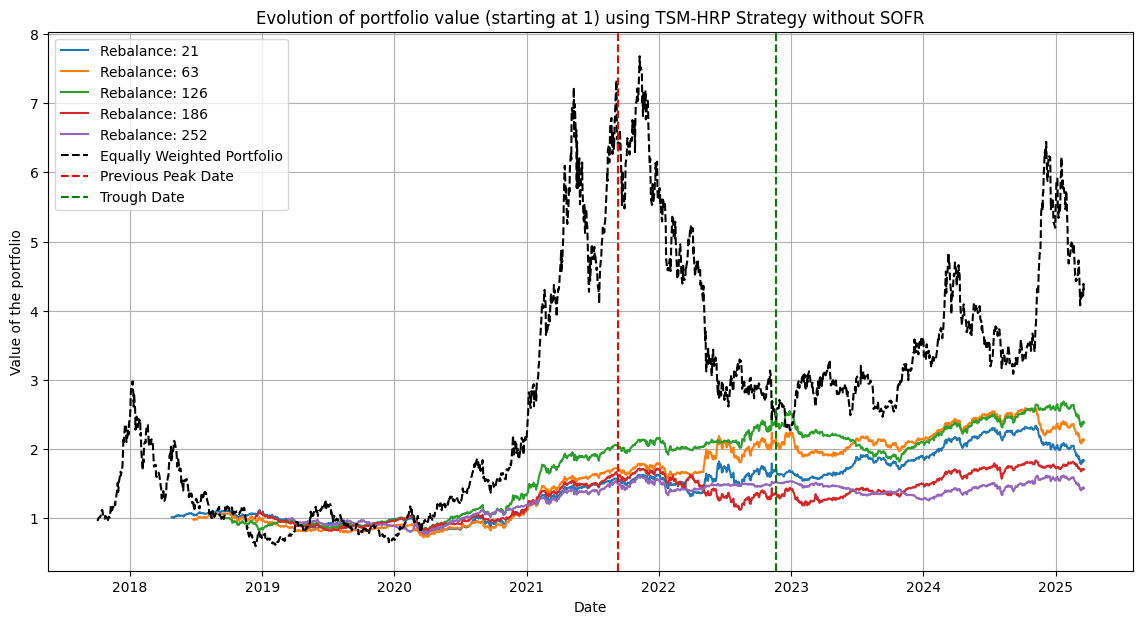

In [69]:
rebalance_frequencies = [21, 63, 126, 186, 252]
# Run strategies, all with lookback of 126 days
lookback = 126
results = []
for rebalance_freq in rebalance_frequencies:
    # Implement the strategy
    strat_returns = implement_hrp_tsm_strategy_copula(rets_sans_sofr, lookback=lookback, rebalance_freq=rebalance_freq)
    results.append((rebalance_freq, strat_returns))
# Plot the results
plt.figure(figsize=(14, 7))
for rebalance_freq, cum_return in results:
    plt.plot(cum_return, label=f'Rebalance: {rebalance_freq}')
plt.plot(ewp_returns, label='Equally Weighted Portfolio', linestyle='--', color='black')
# Add PP and Tr dates
plt.axvline(x=datePP, color='red', linestyle='--', label='Previous Peak Date')
plt.axvline(x=dateTr, color='green', linestyle='--', label='Trough Date')
plt.title('Evolution of portfolio value (starting at 1) using TSM-HRP Strategy without SOFR')
plt.xlabel('Date')
plt.ylabel('Value of the portfolio')
plt.legend()
plt.grid()
plt.show()


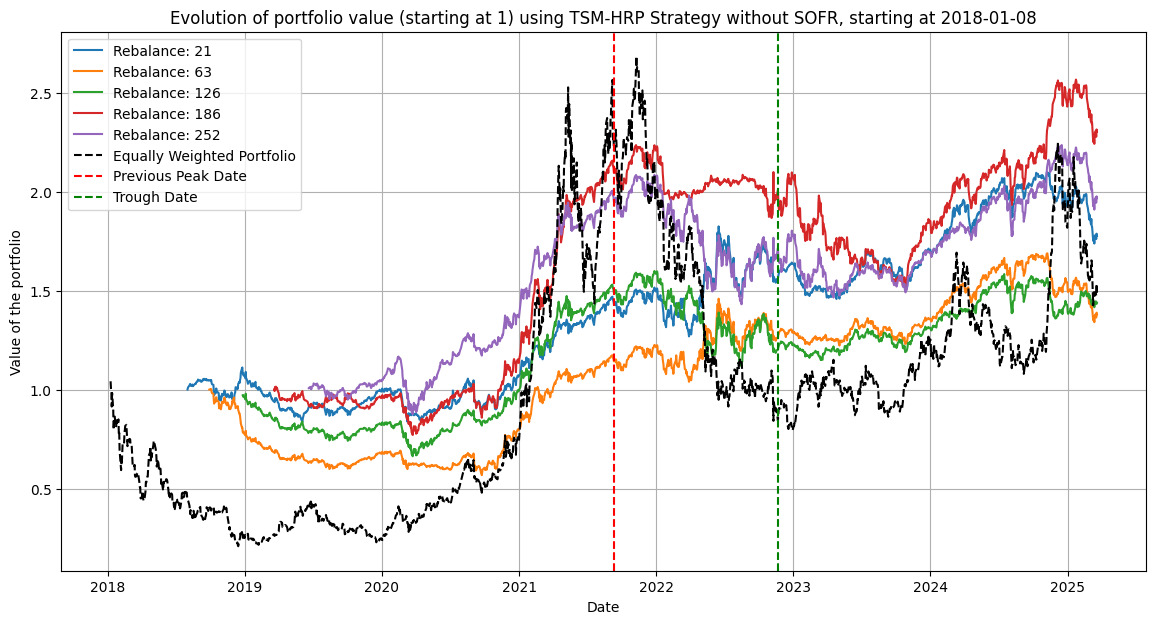

In [65]:
StartDate = '2018-01-08'
rets_sans_sofr_clipped = rets_sans_sofr.loc[StartDate:]
rets_sans_sofr_clipped = rets_sans_sofr_clipped.dropna()

rebalance_frequencies = [21, 63, 126, 186, 252]
# Run strategies, all with lookback of 126 days
lookback = 126
results = []
for rebalance_freq in rebalance_frequencies:
    # Implement the strategy
    strat_returns = implement_hrp_tsm_strategy_copula(rets_sans_sofr_clipped, lookback=lookback, rebalance_freq=rebalance_freq)
    results.append((rebalance_freq, strat_returns))
# Plot the results
ewp_returns = equal_weighted_portfolio(rets_sans_sofr_clipped)
plt.figure(figsize=(14, 7))
for rebalance_freq, cum_return in results:
    plt.plot(cum_return, label=f'Rebalance: {rebalance_freq}')
plt.plot(ewp_returns, label='Equally Weighted Portfolio', linestyle='--', color='black')
# Add PP and Tr dates
plt.axvline(x=datePP, color='red', linestyle='--', label='Previous Peak Date')
plt.axvline(x=dateTr, color='green', linestyle='--', label='Trough Date')
plt.title('Evolution of portfolio value (starting at 1) using TSM-HRP Strategy without SOFR, starting at 2018-01-08')
plt.xlabel('Date')
plt.ylabel('Value of the portfolio')
plt.legend()
plt.grid()
plt.show()
